# IST256 Project Deliverable 3 (P3)

## Phase 3: Data Story / Coding for Explanation

In this step, you submit the final version of your working code. You should be implementing the data story that you discussed in P2 (2.3.1). 

All code necessary to make the project run should be included in this notebook. This include all imports, functions, setup code and your interact. There should be no code that causes errors or exploratory code here.

The expectation is that your instructor can open this notebook, run all cells, and then use your program.

The code you write should be clear, easy to understand and use the affordances learned in the course.

No changes to your code will be considered after this submission. It is important to take prior instructor feedback taken into consideration and these factor into your evaluation.


### Step 1: Summarize Enhancements and Changes

If there were any enhancement or changes to your P3 from your P2 (including those you suggested), please explain them here. For example you might have geocoded your dataset or extracted entities from the text.


### Enhancements from P2:


### Step 2: Project Code

Include all project code below. This includes code that enhances the original dataset. Make sure to execute your code to ensure it runs properly before you turn it in. 

Add as many cells as you need here.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

meteorites = pd.read_csv('Meteorite_Landings.csv')

current_year = pd.Timestamp.now().year
meteorites['year'] = pd.to_numeric(meteorites['year'], errors='coerce')
meteorites = meteorites[(meteorites['year'] <= current_year) & 
                        (meteorites['year'] >= 1800)].copy()

mass_col = [col for col in meteorites.columns if 'mass' in col.lower()][0]
meteorites['mass_g'] = pd.to_numeric(meteorites[mass_col], errors='coerce')

def assign_continent(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return None
    if -60 <= lat <= 15 and -90 <= lon <= -30:
        return 'South America'
    if 15 <= lat <= 75 and -170 <= lon <= -50:
        return 'North America'
    if 35 <= lat <= 75 and -10 <= lon <= 60:
        return 'Europe'
    if -60 <= lat <= 35 and -20 <= lon <= 55:
        return 'Africa'
    if -10 <= lat <= 55 and 60 <= lon <= 180:
        return 'Asia'
    if -90 <= lat <= -60:
        return 'Antarctica'
    if -50 <= lat <= 10 and 110 <= lon <= 180:
        return 'Australia'
    return 'Ocean'

meteorites['continent'] = meteorites.apply(
    lambda x: assign_continent(x['reclat'], x['reclong']), axis=1)

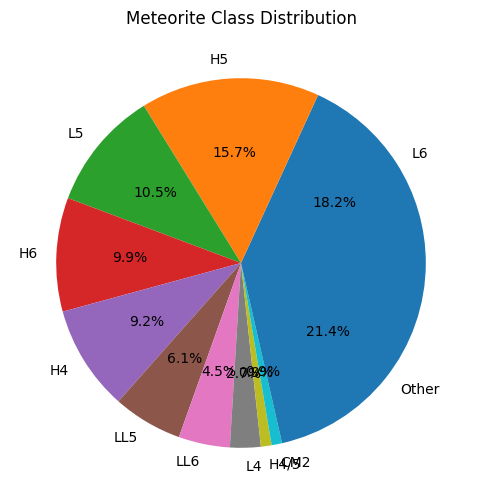

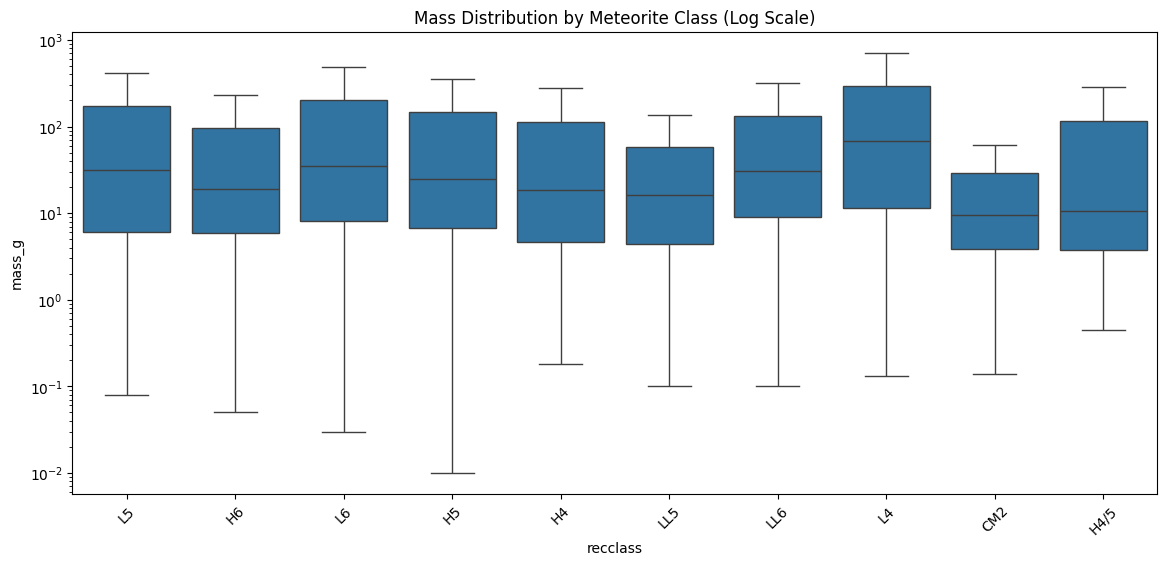

In [4]:
# Class distribution
top_classes = meteorites['recclass'].value_counts().head(10)
other_count = meteorites['recclass'].value_counts()[10:].sum()
top_classes['Other'] = other_count

plt.figure(figsize=(12, 6))
top_classes.plot.pie(autopct='%1.1f%%')
plt.title('Meteorite Class Distribution')
plt.ylabel('')
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(data=meteorites[meteorites['recclass'].isin(top_classes.index)],
            x='recclass', y='mass_g', showfliers=False)
plt.yscale('log')
plt.title('Mass Distribution by Meteorite Class (Log Scale)')
plt.xticks(rotation=45)
plt.show()

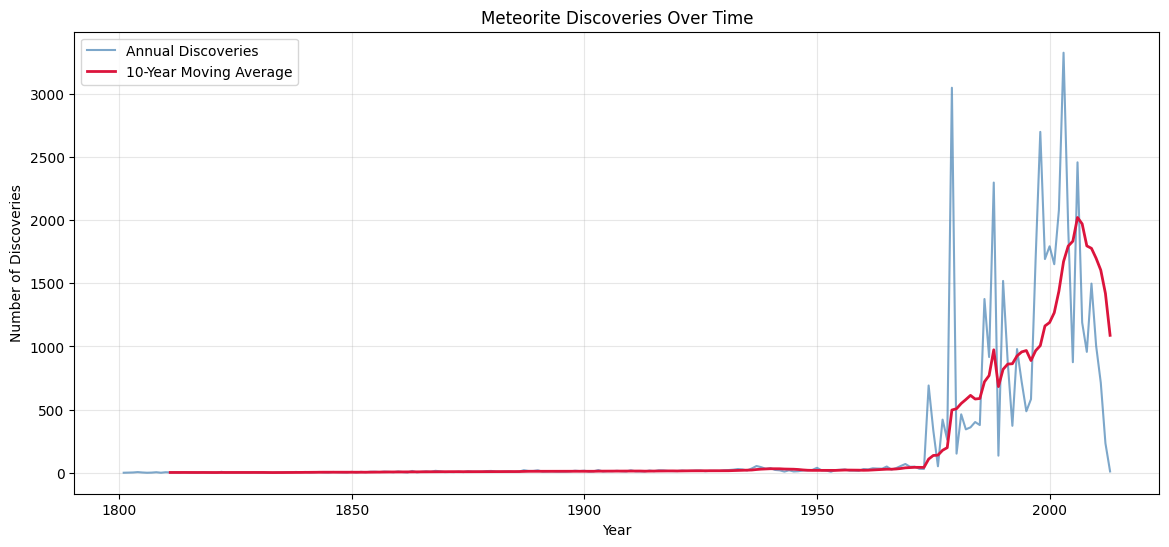

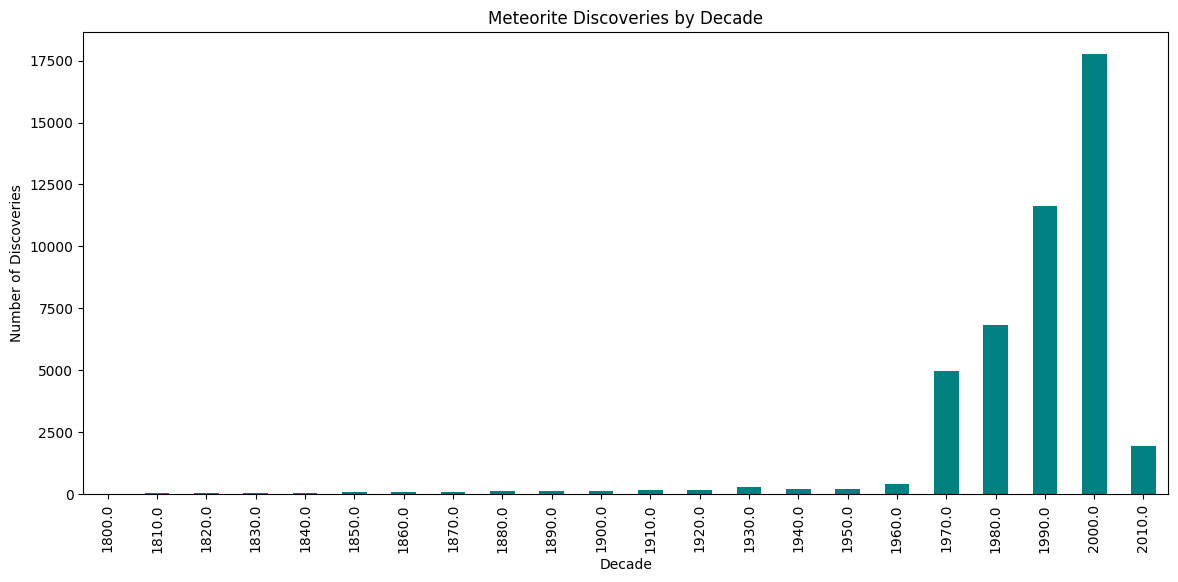

In [5]:
# Discoveries over time with trend line
discoveries_per_year = meteorites['year'].value_counts().sort_index()
plt.figure(figsize=(14, 6))
plt.plot(discoveries_per_year.index, discoveries_per_year.values, 
         color='steelblue', alpha=0.7, label='Annual Discoveries')
plt.plot(discoveries_per_year.rolling(10).mean().index,
         discoveries_per_year.rolling(10).mean().values,
         color='crimson', linewidth=2, label='10-Year Moving Average')
plt.title('Meteorite Discoveries Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Discoveries')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

meteorites['decade'] = (meteorites['year'] // 10) * 10
decade_counts = meteorites.groupby('decade').size()
plt.figure(figsize=(14, 6))
decade_counts.plot.bar(color='teal')
plt.title('Meteorite Discoveries by Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Discoveries')
plt.show()

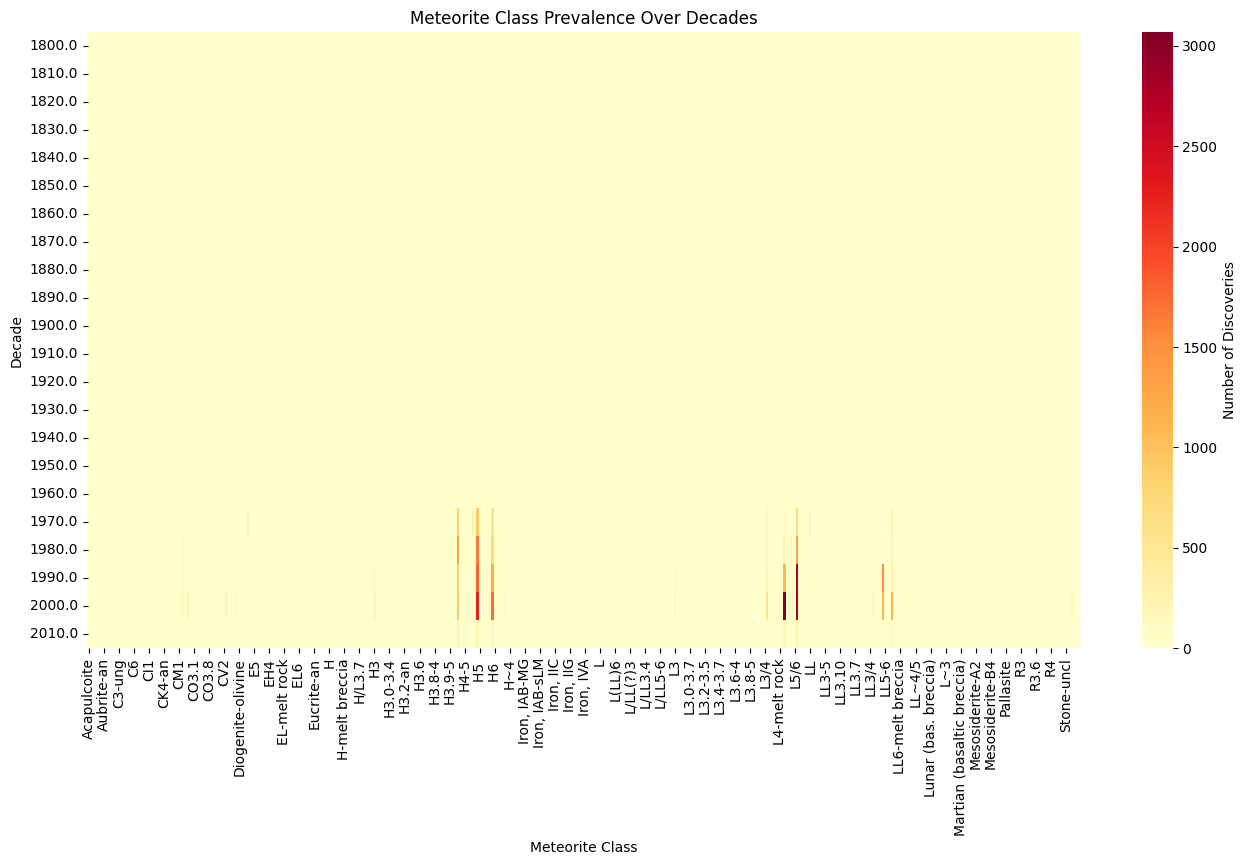

In [6]:
# Class prevalence over time by continent
plt.figure(figsize=(16, 8))
sns.heatmap(pd.crosstab(meteorites['decade'], meteorites['recclass']),
            cmap='YlOrRd', cbar_kws={'label': 'Number of Discoveries'})
plt.title('Meteorite Class Prevalence Over Decades')
plt.xlabel('Meteorite Class')
plt.ylabel('Decade')
plt.show()

In [7]:
!pip install scikit-learn plotly ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 63.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 92.2 MB/s eta 0:00:00:00:0100:01


In [8]:
import pandas as pd
import numpy as np
import plotly.express as px
from IPython.display import display
import ipywidgets as widgets

# Load and clean data
meteorites = pd.read_csv('Meteorite_Landings.csv')
meteorites = meteorites.dropna(subset=['reclat', 'reclong', 'recclass']).copy()
meteorites['mass_g'] = pd.to_numeric(meteorites['mass (g)'], errors='coerce')

# Handle mass data - fill NA and cap large values
median_mass = meteorites['mass_g'].median()
meteorites['mass_clean'] = meteorites['mass_g'].fillna(median_mass)
meteorites['mass_clean'] = np.where(meteorites['mass_clean'] > 10000, 10000, meteorites['mass_clean'])

# Create class explanations dictionary
class_explanations = {
    'H': "Ordinary Chondrite (High iron, 15-20%) - Most common type, contains small spherical chondrules",
    'L': "Ordinary Chondrite (Low iron, 7-11%) - Similar to H but with less metal",
    'LL': "Ordinary Chondrite (Very low iron, 3-5%) - Contains the least metal of ordinary chondrites",
    'CM': "Carbonaceous Chondrite - Contains water and organic compounds, very primitive",
    # ... (keep all your other class explanations)
}

def get_class_explanation(recclass):
    base_class = ''.join([c for c in recclass if not c.isdigit()])
    if recclass in class_explanations:
        return class_explanations[recclass]
    for cls in class_explanations:
        if base_class.startswith(cls):
            return class_explanations[cls]
    return f"This is a {recclass} type meteorite. Specific details about this class are not available."

# Get unique classes for dropdown
unique_classes = sorted(meteorites['recclass'].unique())

# Create widgets
class_search = widgets.Combobox(
    placeholder='Type a meteorite class (e.g., H5, L6)',
    options=unique_classes,
    description='Class:',
    ensure_option=True,
    layout={'width': '400px'}
)

search_button = widgets.Button(description="Show Meteorites", button_style='info')
reset_button = widgets.Button(description="Reset", button_style='warning')

# Create output areas
map_output = widgets.Output()
explanation_output = widgets.Output()

# Display widgets at the top
display(widgets.HBox([class_search, search_button, reset_button]))
display(explanation_output)
display(map_output)

# Function to filter data by class
def filter_by_class(recclass):
    if recclass:
        return meteorites[meteorites['recclass'] == recclass]
    return meteorites

# Function to update map with size scaling
def update_map(df):
    with map_output:
        map_output.clear_output()
        fig = px.scatter_geo(df.sample(min(1000, len(df))),  # Show max 1000 points for better performance
                           lat='reclat',
                           lon='reclong',
                           color='recclass',
                           hover_name='name',
                           size='mass_clean',
                           hover_data={
                               'mass_g': ':.2f',
                               'year': True,
                               'recclass': True,
                               'mass_clean': False,
                               'reclat': False,
                               'reclong': False
                           },
                           projection='natural earth',
                           title=f'<b>Meteorite Landings</b>{" - Showing: "+class_search.value if class_search.value else ""}',
                           size_max=30)
        
        fig.update_traces(
            marker=dict(line=dict(width=0.5, color='DarkSlateGrey')),
            hovertemplate="<b>%{hover_name}</b><br>Class: %{customdata[2]}<br>Mass: %{customdata[0]:.2f}g<br>Year: %{customdata[1]}"
        )
        
        fig.update_geos(
            showcountries=True,
            coastlinecolor="LightGray",
            showocean=True,
            oceancolor="LightBlue"
        )
        fig.update_layout(
            margin={"r":0,"t":40,"l":0,"b":0},
            hovermode='closest'
        )
        fig.show()

# Button click handlers
def on_search_click(b):
    selected_class = class_search.value
    if not selected_class:
        with explanation_output:
            explanation_output.clear_output()
            print("Please select a meteorite class first")
        return
    
    filtered_data = filter_by_class(selected_class)
    update_map(filtered_data)
    
    # Display the explanation
    with explanation_output:
        explanation_output.clear_output()
        explanation = get_class_explanation(selected_class)
        print(f"=== {selected_class} Meteorite Class ===")
        print(explanation)
        print(f"\nFound {len(filtered_data)} meteorites (showing first 1,000)")

def on_reset_click(b):
    class_search.value = ''
    update_map(meteorites)
    with explanation_output:
        explanation_output.clear_output()

# Assign handlers
search_button.on_click(on_search_click)
reset_button.on_click(on_reset_click)

# Show initial map
update_map(meteorites)

Output()

Output()

### Prepare for your Pitch and Reflection (P4)

With the project code complete, its time to prepare for the final deliverable - submitting your project demo Pitch and reflection.


In [ ]:
# run this code to turn in your work!
from casstools.assignment import Assignment
Assignment().submit()

✅ TIMESTAMP  : 2025-05-04 21:18
✅ COURSE     : ist256
✅ TERM       : spring2025
✅ USER       : twbensho@syr.edu
✅ STUDENT    : True
✅ PATH       : ist256/spring2025/lessons/project/P3.ipynb
✅ ASSIGNMENT : P3.ipynb
✅ POINTS     : 0
✅ DUE DATE   : 2025-05-04 23:59
✅ LATE       : False
✅ STATUS     : New Submission



❓ Submit? [y/n] ❓  y
